### Imports

In [1]:
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from sklearn import preprocessing
from transformer import SpaceTimeFormer

### Artificial Time Series

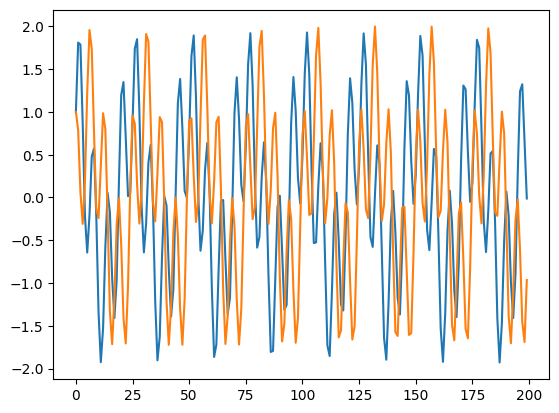

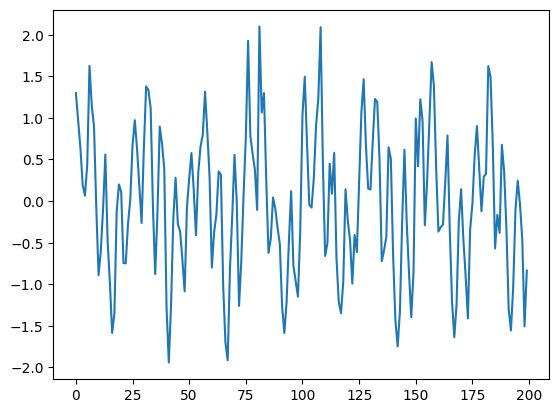

In [64]:
sequence_souce = np.zeros((2,200))
sequence_target = np.zeros((1,200))
sequence_souce[0,:] = np.sin(np.arange(0,200,1))+np.cos(np.arange(0,50,0.25))
sequence_souce[1,:] = np.cos(np.arange(0,200,1))+np.sin(np.arange(0,50,0.25))
sequence_target[0,:] = 0.3*sequence_souce[0,:]+0.7*sequence_souce[1,:]+np.random.normal(0,0.3,200)
plt.plot(sequence_souce[0,:])
plt.plot(sequence_souce[1,:])
plt.show()
plt.plot(sequence_target[0,:])
plt.show()

### Test Data Loader

In [53]:
from utils import load_src_trg

In [54]:
data_iter = load_src_trg(sequence_souce, sequence_target, 5, 2, 2)

In [55]:
for src, trg, trg_y in data_iter:
    print(np.shape(src))
    print(src)
    print(trg)
    print(trg_y)
    break

torch.Size([2, 2, 5])
tensor([[[ 1.0000,  1.8104,  1.7869,  0.8728, -0.2165],
         [ 1.0000,  0.7877,  0.0633, -0.3084,  0.1878]],

        [[ 1.8104,  1.7869,  0.8728, -0.2165, -0.6436],
         [ 0.7877,  0.0633, -0.3084,  0.1878,  1.2326]]], dtype=torch.float64)
tensor([[[1.0835, 0.6139, 0.2291, 0.3416, 1.1023, 1.2284]],

        [[0.6139, 0.2291, 0.3416, 1.1023, 1.2284, 1.2713]]],
       dtype=torch.float64)
tensor([[[1.0835, 0.6139, 0.2291, 0.3416, 1.1023, 1.2284]],

        [[0.6139, 0.2291, 0.3416, 1.1023, 1.2284, 1.2713]]],
       dtype=torch.float64)


### Test Training

In [69]:
split = 0.8
pred_window = 1
seq_length = 6
sequence_source_train = sequence_souce[:, :int(np.shape(sequence_souce)[1]*split)]
sequence_source_test = sequence_souce[:, int(np.shape(sequence_souce)[1]*split):]
sequence_target_train = sequence_target[:, :int(np.shape(sequence_target)[1]*split)]
sequence_target_test = sequence_target[:, int(np.shape(sequence_target)[1]*split):]

In [73]:
model = SpaceTimeFormer(pred_offset = pred_window,
                        input_size = 2,
                        output_size = 1,
                        seq_length = seq_length,
                        embedding_size_time = 3,
                        embedding_size_variable = 5)

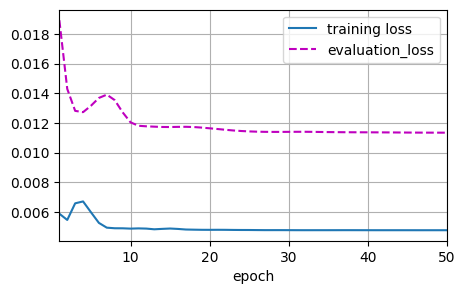

In [74]:
model.start_training(source=sequence_source_train,
                     target=sequence_target_train,
                     loss=nn.MSELoss(),
                     metric=nn.MSELoss(),
                     epochs=50,
                     batch_size=128,
                     learning_rate=1e-3,
                     standardize=False,
                     verbose=False,
                     plot=True)

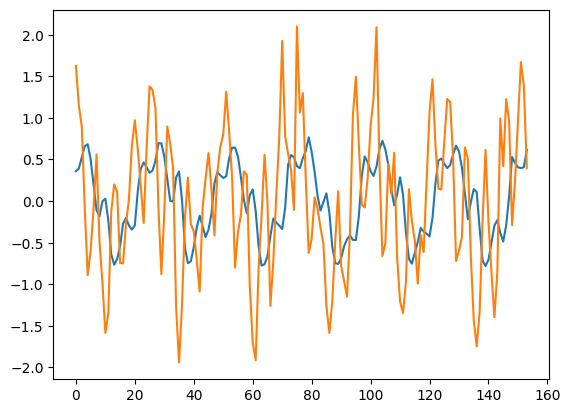

In [75]:
standardize = False
source = sequence_source_train
target = sequence_target_train

if standardize:
    scaler = preprocessing.MinMaxScaler().fit(source.transpose())
    source = scaler.transform(source.transpose()).transpose()
    scaler = preprocessing.MinMaxScaler().fit(target.transpose())
    target = scaler.transform(target.transpose()).transpose()

l = np.shape(sequence_source_train)[1]
y_hat = np.zeros((1,l))
y = target

src_idx_1, src_idx_2 = 0, 0
trg_idx_1, trg_idx_2 = 1, 1

while trg_idx_2 < l:
    src_idx_2 = src_idx_1 + seq_length
    trg_idx_2 = trg_idx_1 + seq_length + pred_window - 1
    
    src = source[:, src_idx_1:src_idx_2]
    trg_stub = target[:, trg_idx_1:trg_idx_2-pred_window]
    y_hat[0, trg_idx_2-pred_window:trg_idx_2] = model.predict(src, trg_stub, False)
    
    src_idx_1 += pred_window
    trg_idx_1 += pred_window

plt.plot(y_hat[0,seq_length:])
plt.plot(y[0,seq_length:])
plt.show()

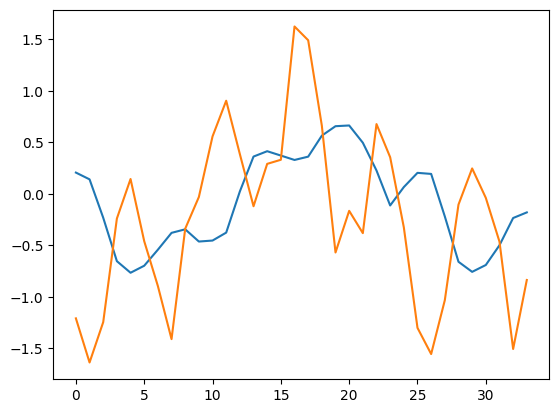

In [76]:
source = sequence_source_test
target = sequence_target_test

if standardize:
    scaler = preprocessing.MinMaxScaler().fit(source.transpose())
    source = scaler.transform(source.transpose()).transpose()
    scaler = preprocessing.MinMaxScaler().fit(target.transpose())
    target = scaler.transform(target.transpose()).transpose()

l = np.shape(source)[1]
y_hat = np.zeros((1,l))
y = target

src_idx_1, src_idx_2 = 0, 0
trg_idx_1, trg_idx_2 = 1, 1

while trg_idx_2 < l:
    src_idx_2 = src_idx_1 + seq_length
    trg_idx_2 = trg_idx_1 + seq_length + pred_window - 1
    
    src = source[:, src_idx_1:src_idx_2]
    trg_stub = target[:, trg_idx_1:trg_idx_2-pred_window]
    y_hat[0, trg_idx_2-pred_window:trg_idx_2] = model.predict(src, trg_stub, False)
    
    src_idx_1 += 1
    trg_idx_1 += 1

plt.plot(y_hat[0,seq_length:])
plt.plot(y[0,seq_length:])
plt.show()